# Reproduce results for figure 2 in our submission

- generates a test dataset with true SWE dynamics
- loads trained models (semi-implicit and explicit)
- runs simulations from initial conditions taken from early time steps of test data simulations
- compares model predictions with future time steps of test dataset

On a modern GPU, this notebook should run in a few minutes !

In [1]:
# for which integration time-step sizes do we want to compare models?
dts = [300., 900., 1500.]

# create test dataset

In [2]:
import numpy as np
import torch
import hydra

from src.utils import swe2D_sim
from implem.data import DataModule

import pytorch_lightning as pl
pl.seed_everything(4321)

# read config from hydra
with hydra.initialize(config_path='configs'):
    cfg = hydra.compose(config_name='defaults.yaml')

n_static_channels = 2
    
# load model to get the necessary logistics for Red-Black Gauss Seidel solver
model = hydra.utils.instantiate(
        cfg.model,
        instance_dimensionality = cfg.data.instance_dimensionality,
        input_channels = 5,
        static_channels = n_static_channels,
        offset = [1],
        _recursive_ = False # necessary for model.configure_optimizers()
)
settings = model.impl_layers[0].settings
del model


# correct initializer for linear solver outside model (model wasn't written for this usage...)
settings['x_init'] = torch.Tensor([]) 

###################
# run simulations #
###################

def normalize_channels(data):
    data_scales = np.sqrt((data**2).mean(axis=tuple([i for i in range(data.ndim) if i != 2])))
    data_scales = data_scales.reshape(1,1,-1,1,1)
    data_scales[0,0,-1] = 1. # don't change binary mask channels
    data /= data_scales      # normalize per channel
    return data

data_all = []

N = 100   # number of simulations to average results over

for dt in dts:

    T = int(25.*3600./dt)          # 25 h simulation time
    assert 1.*T == 25.*3600./dt

    print('simulating test data with (semi-)implicit numerical simulator.')
    print(f'-simulating {T} time steps for integration step-size dt={dt}')
    data_all.append(swe2D_sim(N=N,
                        T=T, 
                        my=100,
                        nx=100,
                        dt=dt,     # temporal discretization [s]
                        dx=1e4,    # physical distance between grid points
                        g=9.81,    # graviation constant
                        w_imp=0.5, # weight between implicit/explicit integration step
                        cd=1e-3,   # coefficient of drag
                        ah=1000.,
                        data_scales=np.ones((1,1,5,1,1)),
                        settings=settings, 
                        verbose=True, 
                        comp_u='calculate', # whether to solve or calculate velocities u. 
                        init_vals=None # initial values for simulation (will be drawn if init_vals=None)
                       )
                   )
    data_all[-1] = normalize_channels(data_all[-1])



using CUDA !


Global seed set to 4321


simulating test data with (semi-)implicit numerical simulator.
-simulating 300 time steps for integration step-size dt=300.0
simulating 0/300
simulating 10/300
simulating 20/300
simulating 30/300
simulating 40/300
simulating 50/300
simulating 60/300
simulating 70/300
simulating 80/300
simulating 90/300
simulating 100/300
simulating 110/300
simulating 120/300
simulating 130/300
simulating 140/300
simulating 150/300
simulating 160/300
simulating 170/300
simulating 180/300
simulating 190/300
simulating 200/300
simulating 210/300
simulating 220/300
simulating 230/300
simulating 240/300
simulating 250/300
simulating 260/300
simulating 270/300
simulating 280/300
simulating 290/300
simulating test data with (semi-)implicit numerical simulator.
-simulating 100 time steps for integration step-size dt=900.0
simulating 0/100
simulating 10/100
simulating 20/100
simulating 30/100
simulating 40/100
simulating 50/100
simulating 60/100
simulating 70/100
simulating 80/100
simulating 90/100
simulating t

# load trained models (one explicit and one semi-implicit per dataset)
- change here to load own (re-)trained models !

In [3]:
from os import listdir
from implem.model.model import LightningImplicitModel
from src.utils import fix_bM_BCs, enforce_bcs

root_lightning = './outputs/'


model_params_base = {
        'instance_dimensionality': '2D', # 2D shallow-water equations
        'input_channels': 5,
        'static_channels': n_static_channels, # number of channels we don't need to predict
        'offset': [1],  # how many steps into the future we want to predict
        'system_determ': [fix_bM_BCs, None], # enforces boundary contsraints on water height for implicit models
        'format_output':  enforce_bcs, # enforces boundary constraints on (u,v) for all models

}

# change these paths for your own trained models !

models_impl_strs = ['SWE2D_dt300/ImplicitModel/min_net0/2021-09-20_031642/',
                    'SWE2D_dt900/ImplicitModel/min_net0/2021-09-20_135046/',
                    'SWE2D_dt1500/ImplicitModel/min_net0/2021-09-20_135813/'
                    #'SWE2D_dt300/ImplicitModel/new_train/____-__-_________/'
                   ]
models_expl_strs = ['SWE2D_dt300/ExplicitModel/min_net0/2021-09-21_224203/', 
                    'SWE2D_dt900/ExplicitModel/min_net0/2021-09-21_224206/', 
                    'SWE2D_dt1500/ExplicitModel/min_net0/2021-09-21_224213/'
                    #'SWE2D_dt300/ExplicitModel/new_train/____-__-_________/'
                   ]

def get_model_path(model_str):
    fls = listdir(root_lightning + model_str + 'checkpoints')
    return root_lightning + model_str + 'checkpoints/' + fls[-1]

def get_model_params(model_str):
    with hydra.initialize(config_path=f"outputs/{model_str}hydra/"):
        cfg = hydra.compose(config_name='config.yaml')
    return {**cfg['model'], **model_params_base}
    

models_impl = [LightningImplicitModel.load_from_checkpoint(
            checkpoint_path=get_model_path(model_str),
    **get_model_params(model_str)) for model_str in models_impl_strs]

models_expl = [LightningImplicitModel.load_from_checkpoint(
            checkpoint_path=get_model_path(model_str),
    **get_model_params(model_str)) for model_str in models_expl_strs]

[model.eval() for model in models_impl]
[model.eval() for model in models_expl]

print('done.')

done.


# model evaluation (single rollout)

dataset: dt = 300.0
model: (semi-)implicit


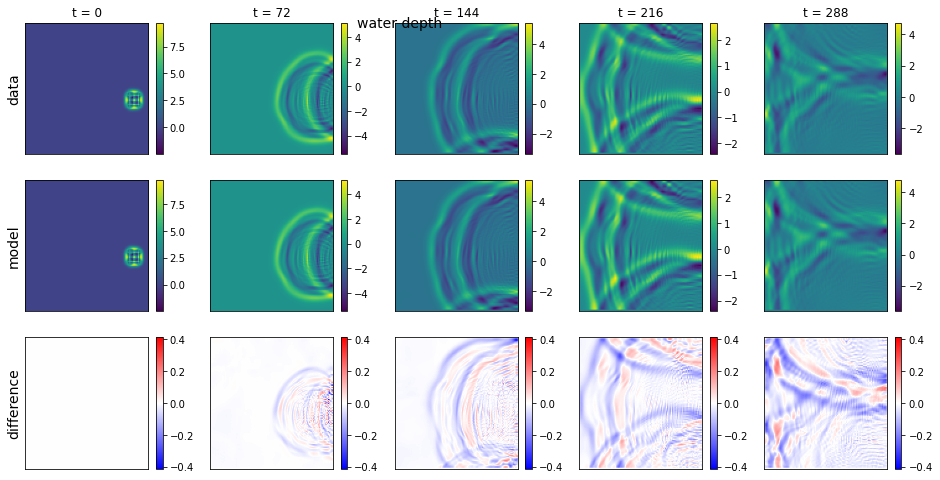

model: explicit


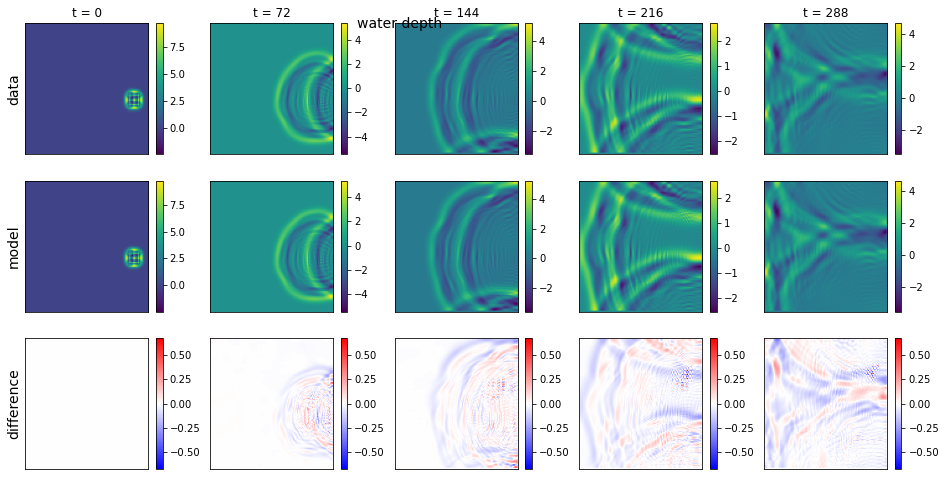

dataset: dt = 900.0
model: (semi-)implicit


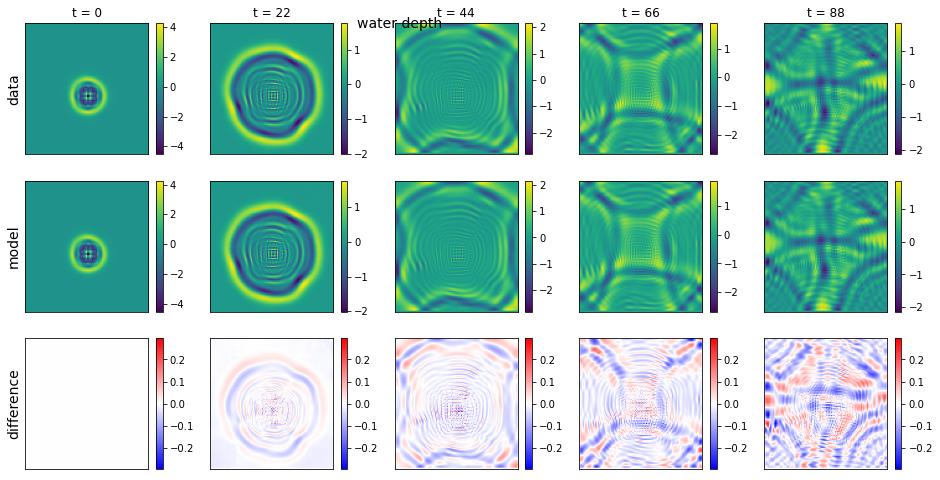

model: explicit


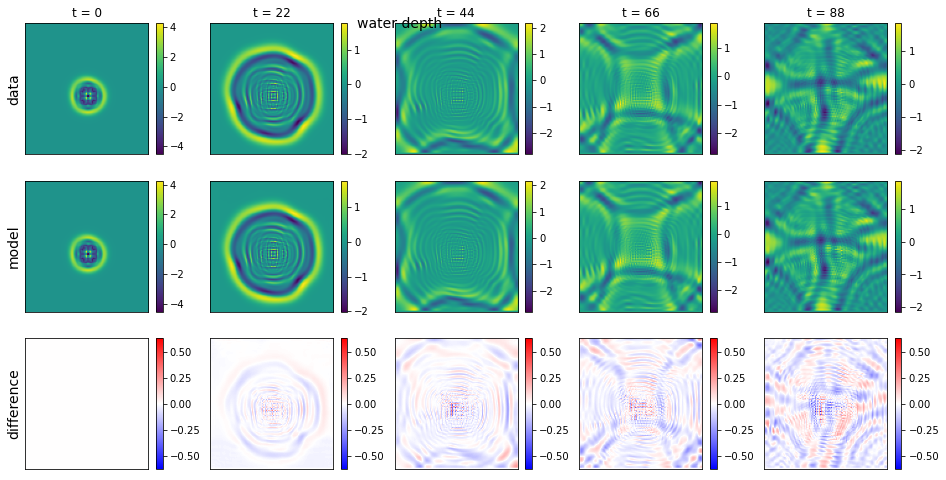

dataset: dt = 1500.0
model: (semi-)implicit


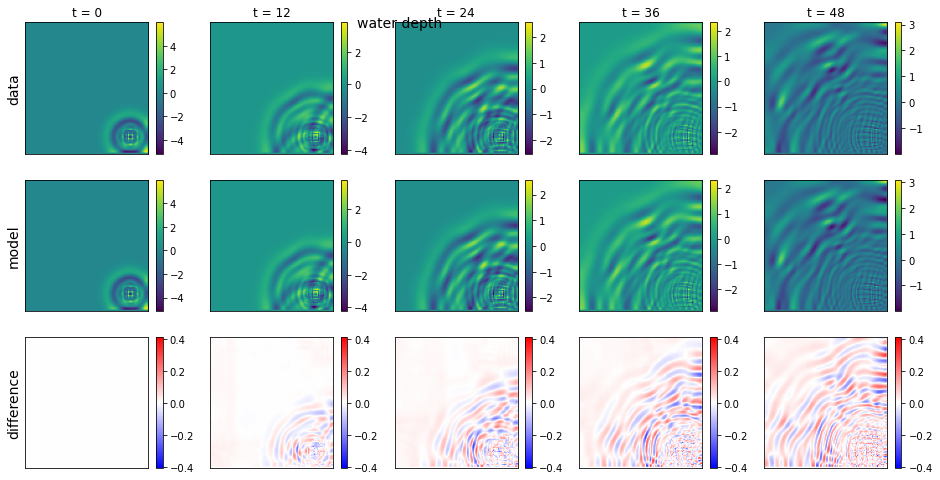

model: explicit


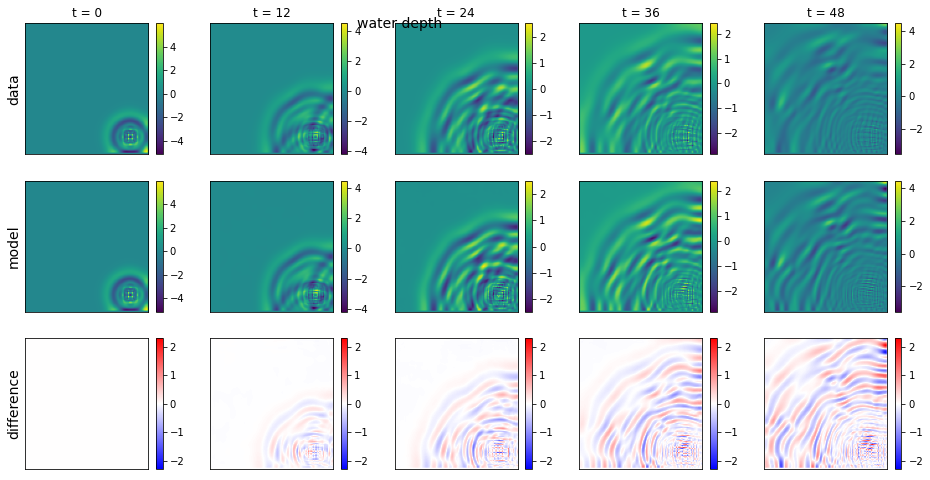

In [4]:
from src.utils import plot_results_swe
from implem.utils import as_tensor, device

def rollout(model, init, statics, T):
    out = []
    with torch.no_grad():
        x = init
        out.append(x[0,:-n_static_channels].unsqueeze(0))
        for t in range(T):
            x = torch.cat((out[-1][0], statics), dim=0).unsqueeze(0)
            out.append(model(x))
    return torch.cat(out, axis=0)

for i in range(len(data_all)):
    
    n, t_start, t_end = -1, 10, data_all[i].shape[1] # trial, starting step, stopping step
    T = t_end-t_start-1

    data, model_impl, model_expl = data_all[i], models_impl[i], models_expl[i]

    init = as_tensor(data[n, t_start]).unsqueeze(0)
    statics = as_tensor(data[n, t_start][-n_static_channels:])

    out_impl = rollout(model_impl.to(device), init, statics, T)
    out_expl = rollout(model_expl.to(device), init, statics, T)

    print('dataset: dt =', dts[i])
    fi = 0
    print('model: (semi-)implicit')
    plot_results_swe(data_numerical=data[n,t_start:t_end:,fi,:], 
                 data_model=out_impl[:,fi,:].cpu().numpy(), 
                 i=fi, swe_model='2D', if_save=False, fig_path=None)

    print('model: explicit')
    plot_results_swe(data_numerical=data[n,t_start:t_end:,fi,:], 
                 data_model=out_expl[:,fi,:].cpu().numpy(), 
                 i=fi, swe_model='2D', if_save=False, fig_path=None)


# model evaluation (RMSEs over time for N=100 different initial conditions)

dataset: dt= 300.0


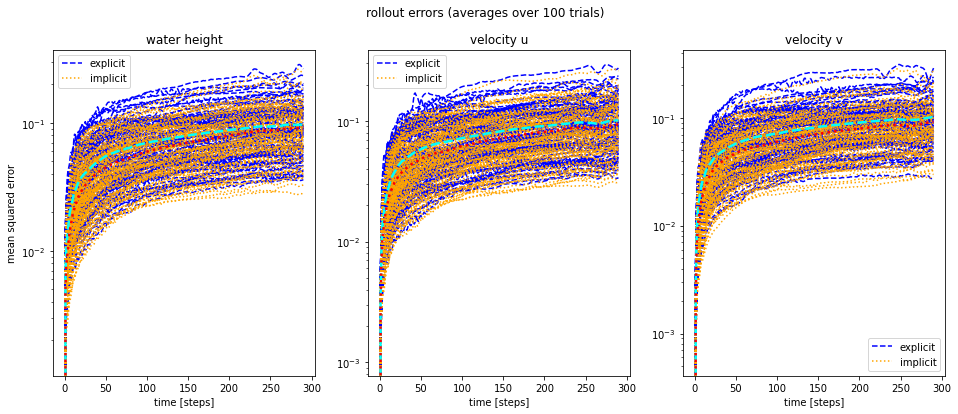

dataset: dt= 900.0


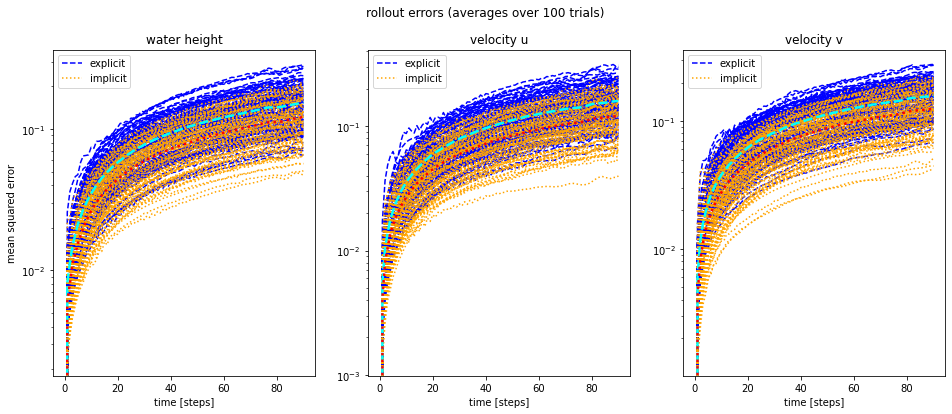

dataset: dt= 1500.0


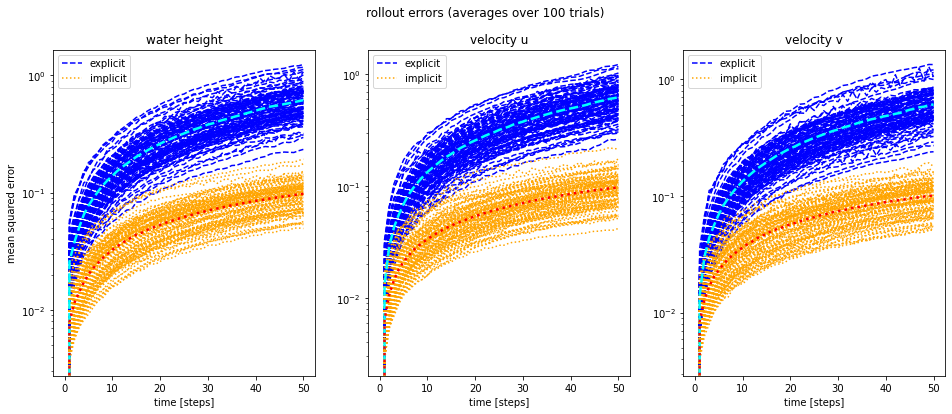

In [5]:
import matplotlib.pyplot as plt

# simple rollout function: self-iterate dynamics model on own output.
def rollout(model, init, statics, T):
    out = []
    with torch.no_grad():
        x = init
        out.append(x[:,:-n_static_channels])
        for t in range(T):
            x = torch.cat((out[-1], statics), dim=1)
            out.append(model(x))
            out[-2] = out[-2].detach().cpu()
        out[-1] = out[-1].detach().cpu()
            
    return torch.stack(out, axis=1)


num_fields = data_all[0].shape[2] - n_static_channels  # number of fields = 3 (water height, u, v)
n = np.arange(N) # trials selected for averaging (we take all simulated ones)

# track mean-square errors between learned dynamics and numerical simulation
MSE_impl = np.nan * np.ones((len(data_all), len(n), max([data.shape[1] for data in data_all]), num_fields))
MSE_expl = np.nan * np.ones_like(MSE_impl)
#MSE_pers = np.nan * np.ones_like(MSE_impl) # persistence model (very low lower bar)

for i in range(len(data_all)):
    
    t_start, t_end = 10, data_all[i].shape[1] # trial, starting step, stopping step
    T = t_end-t_start-1

    data, model_impl, model_expl = data_all[i], models_impl[i], models_expl[i]

    # simulate from contester models
    init = as_tensor(data[n, t_start])
    statics = as_tensor(data[n, t_start][:,-n_static_channels:])

    out_impl = rollout(model_impl.to(device), init, statics, T).detach().cpu().numpy()
    out_expl = rollout(model_expl.to(device), init, statics, T).detach().cpu().numpy()
    #out_pers = init[:,np.newaxis,:num_fields].repeat((1,out_impl.shape[1],1,1,1)).detach().cpu().numpy()

    # gather relevant section of real data
    out_data = data[n,t_start:t_end:,:-n_static_channels,:]

    avg_axis = (-1,-2) # average over spatial dimensions
    MSE_impl[i,:,:out_data.shape[1]] = np.nanmean((out_data - out_impl)**2, axis=avg_axis)
    MSE_expl[i,:,:out_data.shape[1]] = np.nanmean((out_data - out_expl)**2, axis=avg_axis)
    #MSE_pers[i,:,:out_data.shape[1]] = np.nanmean((out_data - out_pers)**2, axis=avg_axis)

    print('dataset: dt=',  dts[i])
    plt.figure(figsize=(16,6))
    for fi in range(num_fields):
        plt.subplot(1, num_fields, fi+1)
        plt.semilogy(np.sqrt(MSE_expl[i,:1,:,fi]).T, '--', color='blue', label='explicit')
        plt.semilogy(np.sqrt(MSE_expl[i,1:,:,fi]).T, '--', color='blue')
        plt.semilogy(np.sqrt(MSE_impl[i,:1,:,fi]).T, ':', color='orange', label='implicit')        
        plt.semilogy(np.sqrt(MSE_impl[i,1:,:,fi]).T, ':', color='orange')
        #plt.semilogy(np.sqrt(MSE_pers[i,:,:,fi]).T, '.-', color='black')
        plt.semilogy(np.sqrt(MSE_expl[i,:,:,fi]).T.mean(axis=1), '--', color='cyan', linewidth=2.5)
        plt.semilogy(np.sqrt(MSE_impl[i,:,:,fi]).T.mean(axis=1), ':', color='red', linewidth=2.5)
        #plt.semilogy(np.sqrt(MSE_pers[i,:,:,fi]).T.mean(axis=1), '.-', color='black', linewidth=2.5)

        plt.xlabel('time [steps]')
        if fi == 0:
            field = 'water height'
            plt.ylabel('mean squared error')
        elif fi == 1:
            field = 'velocity u'
        elif fi == 2:
            field = 'velocity v'            
        plt.title(field)
        plt.legend()
    plt.suptitle(f'rollout errors (averages over {len(n)} trials)')
    plt.show()


# Figure panel 2b

In [6]:
import os 

fig_dir = './figs/' # figure directory

try:
    os.stat(fig_dir)
except:
    os.mkdir(fig_dir)

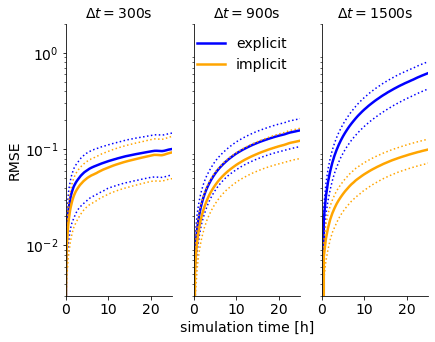

In [7]:
plt.figure(figsize=(6.5,5))

dt_min = min(dts)
fontsize=14

for i in range(len(data_all)):
    ax = plt.subplot(1,3,i+1)
    
    # MSEs with dts > dt_min can be NaN because simulations had fewer steps
    n_good = np.invert(np.isnan(MSE_expl[i].sum(axis=(0,2)))).sum() 
    times = np.linspace(0, dt_min * MSE_expl.shape[-2], n_good)
    
    """
    # leave out persistence model from plotting - fig 2c shows that persistence must be awful
    mean = np.sqrt(MSE_pers[i,:,:n_good].mean(axis=-1)).mean(axis=0)
    std = np.sqrt(MSE_pers[i,:,:n_good].mean(axis=-1)).std(axis=0)    
    plt.semilogy(times, mean, '-', color='black', linewidth=1.5, label='persistence')
    plt.semilogy(times, mean-std, ':', color='black', linewidth=1.5)
    plt.semilogy(times, mean+std, ':', color='black', linewidth=1.5)
    """

    mean = np.sqrt(MSE_expl[i,:,:n_good].mean(axis=-1)).mean(axis=0)
    std = np.sqrt(MSE_expl[i,:,:n_good].mean(axis=-1)).std(axis=0)    
    plt.semilogy(times, mean, '-', color='blue', linewidth=2.5, label='explicit')
    plt.semilogy(times, mean-std, ':', color='blue', linewidth=1.5)
    plt.semilogy(times, mean+std, ':', color='blue', linewidth=1.5)
    
    mean = np.sqrt(MSE_impl[i,:,:n_good].mean(axis=-1)).mean(axis=0)
    std = np.sqrt(MSE_impl[i,:,:n_good].mean(axis=-1)).std(axis=0)    
    plt.semilogy(times, mean, '-', color='orange', linewidth=2.5, label='implicit')
    plt.semilogy(times, mean-std, ':', color='orange', linewidth=1.5)
    plt.semilogy(times, mean+std, ':', color='orange', linewidth=1.5)

    plt.axis([0, dt_min * MSE_expl.shape[-2], 3e-3, 2e0])

    plt.xticks([0, 36000, 72000], [0, 10, 20], fontsize=fontsize)
    plt.title(r'$\Delta{}t = $'+ str(int(dts[i])) +'s', fontsize=fontsize)
    plt.yticks([])
    if i == 0:
        plt.yticks([1e-2, 1e-1, 1e0], fontsize=fontsize)
        plt.ylabel('RMSE', fontsize=fontsize)
    if i == 1:
        plt.xlabel('simulation time [h]', fontsize=fontsize)
        plt.legend(fontsize=fontsize, frameon=False)
    if i == 2:
        pass

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.savefig(fig_dir + 'fig2b.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


# Figure panel 2c

example simulation for stepsize dt= 1500.0


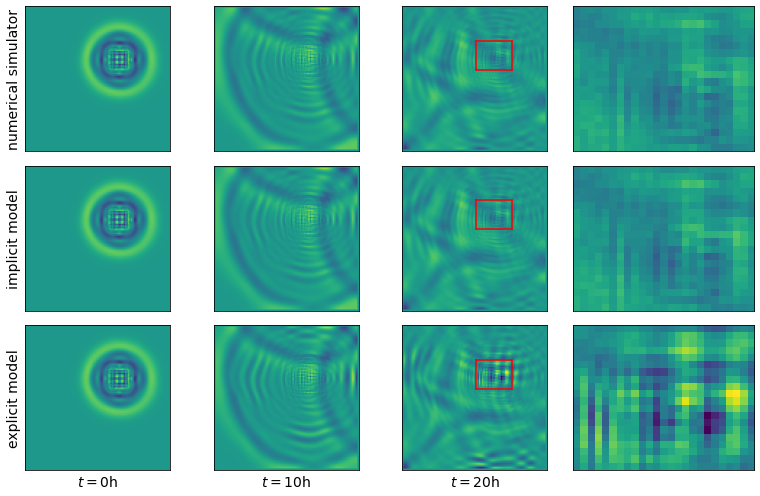

In [8]:
from src.utils import plot_results_swe

# simple rollout function: self-iterate dynamics model on own output (single-trial version).
def rollout(model, init, statics, T):
    out = []
    with torch.no_grad():
        x = init
        out.append(x[0,:-n_static_channels].unsqueeze(0))
        for t in range(T):
            x = torch.cat((out[-1][0], statics), dim=0).unsqueeze(0)
            out.append(model(x))
    return torch.cat(out, axis=0)

i = -1 # dataset
print('example simulation for stepsize dt=', dts[i])

n = 0        # trial
t_start = 12 # 12 steps from initial perturbation (give some time to settle state)
t_end = data_all[i].shape[1] # simulate rest of trajectory

T = t_end-t_start-1

data, model_impl, model_expl = data_all[i], models_impl[i], models_expl[i]

init = as_tensor(data[n, t_start]).unsqueeze(0)
statics = as_tensor(data[n, t_start][-n_static_channels:])

out_impl = rollout(model_impl.to(device), init, statics, T)
out_expl = rollout(model_expl.to(device), init, statics, T)

fi = 0 # plot water height

plt.figure(figsize=(16,7))

ts = [0, 24, 48] # 0h, 10h and 20h after inital state
data_rel = data[n, t_start:t_start+max(ts),fi]
vmin, vmax = data_rel.min(), data_rel.max()
fontsize = 14

for si, ti in enumerate(ts): 
    ax = plt.subplot(3,4,1+si)
    plt.imshow(data[n, t_start+ti,fi], vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    if si == 0:
        plt.ylabel('numerical simulator', fontsize=fontsize)

    ax = plt.subplot(3,4,5+si)
    plt.imshow(out_impl.detach().cpu().numpy()[ti,fi], vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    if si == 0:
        plt.ylabel('implicit model', fontsize=fontsize)
        
    # this has funny interactions with plt.tight_layout() below, but works to squash in horizontal direction
    box = ax.get_position()        
    box.x0 -= 0.3
    box.x1 -= 0.3
    ax.set_position(box)    


    ax = plt.subplot(3,4,9+si)
    plt.imshow(out_expl.detach().cpu().numpy()[ti,fi], vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    if si == 0:
        plt.ylabel('explicit model', fontsize=fontsize)
    plt.xlabel(r'$t = ' + str(int((ti)*1500/3600)) + '$h', fontsize=fontsize)


l, r, u, d = 50, 75, 23, 43 # zoom in to some relevant area (pick by eye, depends on seed etc. !)

for i in range(3):
    plt.subplot(3,4,3+4*i)
    plt.plot([l+.5,r+.5], [u+.5,u+.5], 'r')
    plt.plot([l+.5,r+.5], [d+.5,d+.5], 'r')
    plt.plot([l+.5,l+.5], [u+.5,d+.5], 'r')
    plt.plot([r+.5,r+.5], [u+.5,d+.5], 'r')

ax = plt.subplot(3,4,4)

plt.imshow(data[n, t_start+ti,fi][u:d, l:r], vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(3,4,8)
plt.imshow(out_impl.detach().cpu().numpy()[ti,fi][u:d, l:r], vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(3,4,12)
plt.imshow(out_expl.detach().cpu().numpy()[ti,fi][u:d, l:r], vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])

plt.tight_layout()

plt.savefig(fig_dir + 'fig2c.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

# figure panel 2a

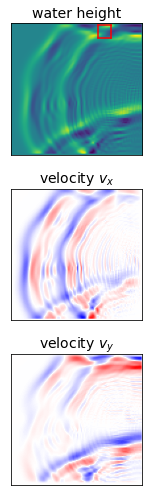

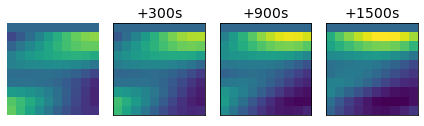

In [9]:
# pick dataset simulated with with dt=300.
data = data_all[0]

n, t  = 1, 200 # pick trial and time point

# zoom in to some relevant area (see second figure below)
l, r, u, d = 65, 75, 0, 10 # pick by eye, depends on seed etc. !

fontsize=14

plt.figure(figsize=(5,7))
plt.subplot(3,1,1)
plt.imshow(data[n, t, 0])
plt.title('water height', fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.plot([l+.5,r+.5], [u+.5,u+.5], 'r')
plt.plot([l+.5,r+.5], [d+.5,d+.5], 'r')
plt.plot([l+.5,l+.5], [u+.5,d+.5], 'r')
plt.plot([r+.5,r+.5], [u+.5,d+.5], 'r')

plt.subplot(3,1,2)
c = np.max((data[n, t, 2].max(), -data[n, t, 2].min()))
plt.imshow(data[n, t, 2], cmap='bwr', vmax=c, vmin=-c)
plt.title(r'velocity $v_x$', fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.subplot(3,1,3)
c = np.max((data[n, t, 1].max(), -data[n, t, 1].min()))
plt.imshow(data[n, t, 1], cmap='bwr', vmax=c, vmin=-c)
plt.title(r'velocity $v_y$', fontsize=fontsize)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig(fig_dir + 'fig2a.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


# inset figure with zoom-in on small region to give idea of step-size scales

plt.figure(figsize=(6, 2))

dt_show = 1
t_show = t

vmax = data[n, t_show:t_show+5, 0][:, u:d, l:r].max()
vmin = data[n, t_show:t_show+5, 0][:, u:d, l:r].min()

plt.subplot(1,4,1)
plt.imshow(data[n, t_show, 0][u:d, l:r], vmax=vmax, vmin=vmin)
plt.axis('off')

ii = 2
for i in [1,3,5]:
    ax = plt.subplot(1,4,ii)
    t_show = t+(i)*dt_show
    plt.imshow(data[n, t_show, 0][u:d, l:r], vmax=vmax, vmin=vmin)
    #plt.title('+ '+ str(i+1) + r' $\Delta{}t$', fontsize=fontsize)
    plt.title(r'$+ '+ str((i)*300) + '$s', fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])

    # this has funny interactions with plt.tight_layout() below, but works to squash in horizontal direction
    box = ax.get_position()        
    box.x0 -= 0.2 * (i+1)//2
    box.x1 -= 0.2 * (i+2)//2
    ax.set_position(box)   

    ii += 1

plt.tight_layout()
plt.savefig(fig_dir + 'fig2a_inset.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# figure panel 1a: example A and its inverse

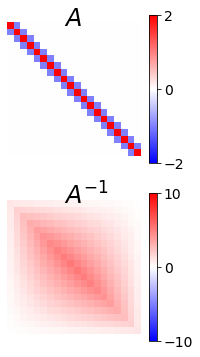

In [10]:
n = 20

A = 2.* np.eye(n) - 1.0*np.diag(np.ones(n-1), k=1) - 1.0*np.diag(np.ones(n-1), k=-1)

Ai = np.linalg.inv(A)

fontsize = 14
fontsize_L = 24

plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
plt.imshow(A, cmap='bwr', vmin=-2, vmax=2)
plt.text(8, 0, r'$A$', fontsize=fontsize_L)
plt.axis('off')
cbar = plt.colorbar(ticks=[2., 0., -2])
cbar.ax.tick_params(labelsize=fontsize)
plt.subplot(2,1,2)
plt.imshow(Ai, cmap='bwr', vmin=-10, vmax=10)
plt.text(8, 0, r'$A^{-1}$', fontsize=fontsize_L)
cbar = plt.colorbar(ticks=[10., 0., -10.])
cbar.ax.tick_params(labelsize=fontsize)
plt.axis('off')
plt.savefig(fig_dir + 'fig1a.pdf', bbox_inches='tight', pad_inches=0)
plt.show()